In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from torch.optim import SGD, Adam
from tqdm import tqdm
from utils import Encoder, Decoder, awgn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [2]:
M = 16 # number of constellation points
flag_train_model = True # True: train model, False: load pre-trained model
Path = "./models/ae_simo_awgn_16qam.pth"
encoder = Encoder([M, 10, 10, 2]).to(device)
decoder = Decoder([4, 20, 20, M]).to(device)

In [3]:
if not flag_train_model:
    # read model if exists else train model
    checkpoint = torch.load(Path, map_location=torch.device('cpu'))
    encoder.load_state_dict(checkpoint["Encoder"])
    decoder.load_state_dict(checkpoint["Decoder"])
    print("Model loaded")

epoch=999: 100%|██████████| 1000/1000 [00:30<00:00, 32.70it/s]


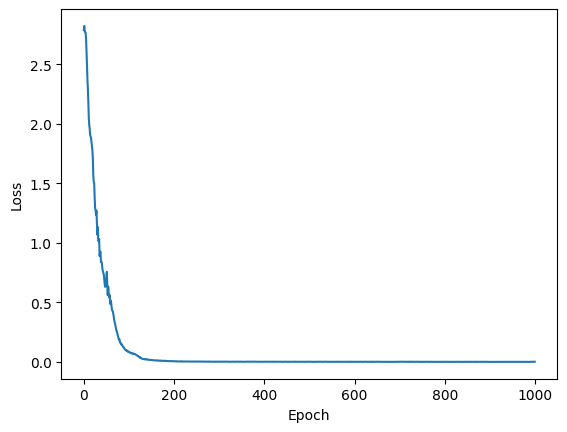

Model saved


In [4]:
if flag_train_model:
    train_snr = 15 # training SNR in dB
    criterion = nn.NLLLoss()     # negative log likelihood loss
    para = list(encoder.parameters()) + list(decoder.parameters())  # get all parameters
    opt = Adam(para, lr=0.001)
    loss = []  # store the loss value
    totEpoch = int(1e4)  # total number of epochs
    iteration = tqdm(range(totEpoch), desc="loss")

    for iterator in iteration:
        iteration.set_description("epoch={:}".format(iterator))
        messages = torch.randint(0, M, size=(51200,), device=device)  # generate 
        one_hot = F.one_hot(messages, M).float()  # convert to one hot encoding shape=(16000, M)
        tx =encoder(one_hot)

        rx1 = awgn(tx, train_snr)
        rx2 = awgn(tx, train_snr)
        rx = torch.cat((rx1, rx2), dim=1)

        y_pred = decoder(rx)

        cross_entropy = criterion(y_pred, messages)

        opt.zero_grad()
        cross_entropy.backward()
        opt.step()
        
        loss.append(cross_entropy.item())


    # plot the loss
    plt.figure()
    plt.plot(loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # save the model
    torch.save({
            'Encoder': encoder.state_dict(),
            'Decoder': decoder.state_dict(),
            }, Path)
    print("Model saved")



SNR:  0 SER:  0.6341112659235669
SNR:  2 SER:  0.5340605095541401
SNR:  4 SER:  0.4126154458598726
SNR:  6 SER:  0.2797283041401274
SNR:  8 SER:  0.1555453821656051
SNR:  10 SER:  0.0642406449044586
SNR:  12 SER:  0.01664012738853503
SNR:  14 SER:  0.002272093949044586
SNR:  16 SER:  0.00012440286624203822
SNR:  18 SER:  9.952229299363056e-07
SNR:  20 SER:  7.497600767754318e-09


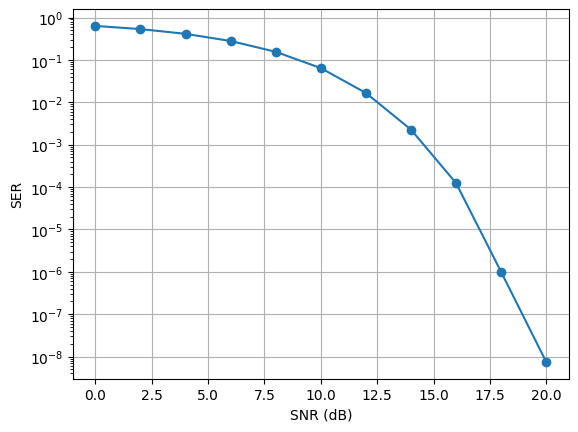

In [11]:
SNR_dB = np.arange(0, 20, 1)

# Monte Carlo simulation of the SER for the trained model
SER = np.array([])
for snr in SNR_dB:
    num_mess = 6400  # number of messages to test
    minErr = 1  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    totSym = 0  # total number of symbols
    totErr = 0  # total number of errors
    while totErr < minErr or totSym < minSym:
        messages = torch.randint(0, M, size=(num_mess,)).to(device)
        one_hot = F.one_hot(messages).float()
        tx = encoder(one_hot)
        rx1 = awgn(tx, snr)
        rx2 = awgn(tx, snr)
        rx = torch.cat((rx1, rx2), dim=1)
        y_pred = decoder(rx)
        y_pred = y_pred.argmax(dim=1)
        totErr += (y_pred != messages).sum().item()
        totSym += num_mess
    SER = np.append(SER, totErr / totSym)
    print("SNR: ", snr, "SER: ", SER[-1])
    


plt.figure()
plt.plot(SNR_dB, SER, "o-")
plt.yscale("log")
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.grid()

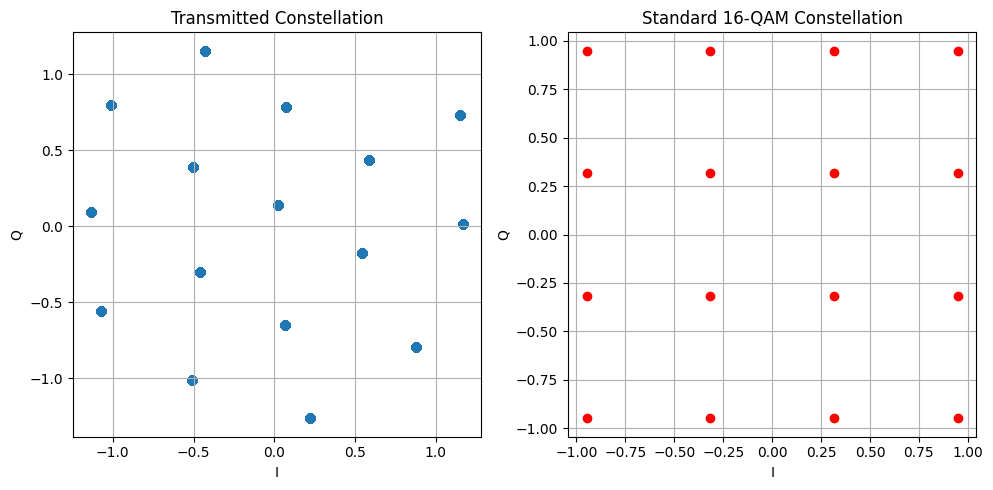

In [12]:
# Generate transmitted symbols using the encoder
num_mess = 6400  # number of messages to test
messages = torch.randint(0, M, size=(num_mess,)).to(device)
one_hot = F.one_hot(messages).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()

# Define the coordinates for 16-QAM constellation points
points_I = np.array([1, 1, 1, 1, -1, -1, -1, -1, 3, 3, 3, 3, -3, -3, -3, -3]) / np.sqrt(10)
points_Q = np.array([3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3]) / np.sqrt(10)

# Plot both constellations
plt.figure(figsize=(10, 5))

# Plot transmitted symbols
plt.subplot(1, 2, 1)
plt.scatter(tx[:, 0], tx[:, 1])
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Transmitted Constellation")
plt.grid(True)

# Plot standard 16-QAM constellation
plt.subplot(1, 2, 2)
plt.scatter(points_I, points_Q, c="r")
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Standard 16-QAM Constellation")
plt.grid(True)

plt.tight_layout()
plt.show()